C:\Users\20529\AppData\Local\Temp\ipykernel_6116\1555615215.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=2, fliersize=4, palette=palette, zorder=2)
C:\Users\20529\AppData\Local\Temp\ipykernel_6116\1555615215.py:23: UserWarning: 
The palette list has fewer values (8) than needed (26) and will cycle, which may produce an uninterpretable plot.
  box_plot = sns.boxplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=2, fliersize=4, palette=palette, zorder=2)
C:\Users\20529\AppData\Local\Temp\ipykernel_6116\1555615215.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin_plot = sns.violinplot(x=df.columns[0], y=df.columns[1]

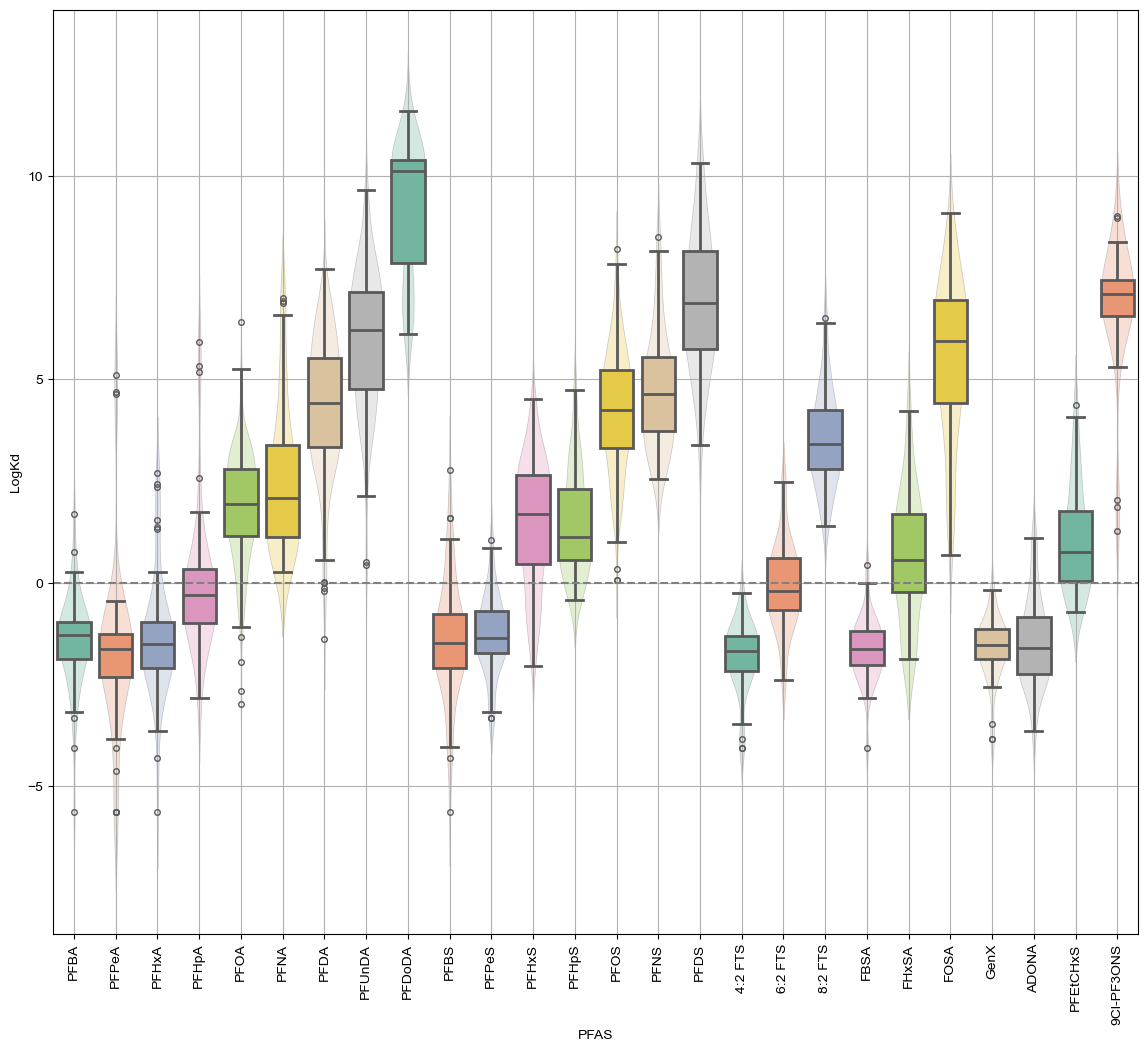

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set global parameters for plotting
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
palette = sns.color_palette("Set2")

# Read data
df = pd.read_excel('../data/data-3.xlsx')

# Caculate mean and standard deviation
mean = df.iloc[:, 1].mean()
std = df.iloc[:, 1].std()

# Remove outliers
df = df[(df.iloc[:, 1] > mean - 3*std) & (df.iloc[:, 1] < mean + 3*std)].dropna()

# Visualize data distribution with boxplot and violinplot
plt.figure(figsize=(14, 12))
box_plot = sns.boxplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=2, fliersize=4, palette=palette, zorder=2)
violin_plot = sns.violinplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=0.5, inner=None, 
                              palette=palette, alpha=0.3, zorder=1)

plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.grid(True)

plt.savefig('../figures/Boxplot_of_LogKd.svg', dpi=300, format='svg')
plt.show()

In [2]:
import numpy as np
import pandas as pd
from math import sqrt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Read data
data = pd.read_excel('../data/data-3.xlsx')

# Separate features and target variable
X = data.drop(['PFAS', 'LogKd'], axis=1)
y = data['LogKd']

# Split dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_models = {}

# Define models and hyperparameter spaces
model_spaces = {

    'GBRT': {'model': GradientBoostingRegressor,'params': {
            'n_estimators': hp.choice('gbrt_n_estimators', range(100, 1001)),
            'learning_rate': hp.loguniform('gbrt_learning_rate', np.log(0.01), np.log(0.3)),
            'max_depth': hp.choice('gbrt_max_depth', range(1, 11)),
            'min_samples_split': hp.uniform('gbrt_min_samples_split', 0.1, 1.0),
            'min_samples_leaf': hp.uniform('gbrt_min_samples_leaf', 0.1, 0.5)}},

    'RF': {'model': RandomForestRegressor,'params': {
            'n_estimators': hp.choice('rf_n_estimators', range(100, 1001)),
            'max_depth': hp.choice('rf_max_depth', range(1, 21)),
            'min_samples_split': hp.choice('rf_min_samples_split', range(2, 11)),
            'min_samples_leaf': hp.choice('rf_min_samples_leaf', range(1, 11)),
            'max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]),
            'bootstrap': hp.choice('rf_bootstrap', [True, False])}},

    'KNN':{'model': KNeighborsRegressor,'params': {
        'n_neighbors': hp.choice('knn_n_neighbors', range(1, 31)),
        'weights': hp.choice('knn_weights', ['uniform', 'distance']),
        'algorithm': hp.choice('knn_algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': hp.choice('knn_leaf_size', range(1, 50)),
        'p': hp.choice('knn_p', [1, 2]) 
    }}, 

    'MLR': {'model': LinearRegression, 'params': {'fit_intercept': hp.choice('mlr_fit_intercept', [True, False])}}}

# Define the objective function
def objective(params, model, X, y):
    reg = model(**params)
    kf = KFold(n_splits=5)
    scores = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_squared_error')
    return {'loss': -np.mean(scores), 'status': STATUS_OK}

# Otimize
for model_name, space in model_spaces.items():
    print(f"Optimizing {model_name}")
    trials = Trials()
    best = fmin(fn=lambda params: objective(params, space['model'], X_train_full, y_train_full),
                space=space['params'], algo=tpe.suggest, max_evals=50, trials=trials,rstate=np.random.default_rng(42))
    
    best_params = space_eval(space['params'], best)
    print(f"Best params for {model_name}: {best_params}")
    
    # Use the best parameters to evaluate the model on the test set
    model = space['model'](**best_params)
    
    model.fit(X_train_full, y_train_full)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred)) 
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} on test set - RMSE: {rmse}, MAE: {mae}, R^2: {r2}\n")

    # Train the final model with the best parameters on the full training set
    model = space['model'](**best_params)
    model.fit(X_train_full, y_train_full)
    
    # Save the final model
    final_models[model_name] = model

Optimizing GBRT
100%|██████████| 50/50 [01:52<00:00,  2.25s/trial, best loss: 1.01896468457095]  
Best params for GBRT: {'learning_rate': 0.07761833308846404, 'max_depth': 6, 'min_samples_leaf': 0.10171872147425852, 'min_samples_split': 0.11066771511218385, 'n_estimators': 284}
GBRT on test set - RMSE: 1.0395096206332395, MAE: 0.7181121424049216, R^2: 0.8970351829130714

Optimizing RF
100%|██████████| 50/50 [03:19<00:00,  4.00s/trial, best loss: 0.8154476779659365]
Best params for RF: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 744}
RF on test set - RMSE: 0.8540893386570327, MAE: 0.5808004872665717, R^2: 0.9304914181902308

Optimizing KNN
100%|██████████| 50/50 [00:02<00:00, 21.60trial/s, best loss: 1.2300851700299864]
Best params for KNN: {'algorithm': 'auto', 'leaf_size': 26, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
KNN on test set - RMSE: 1.116589534824627, MAE: 0.7564122617546284, R^2: 0.881199

d:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor 

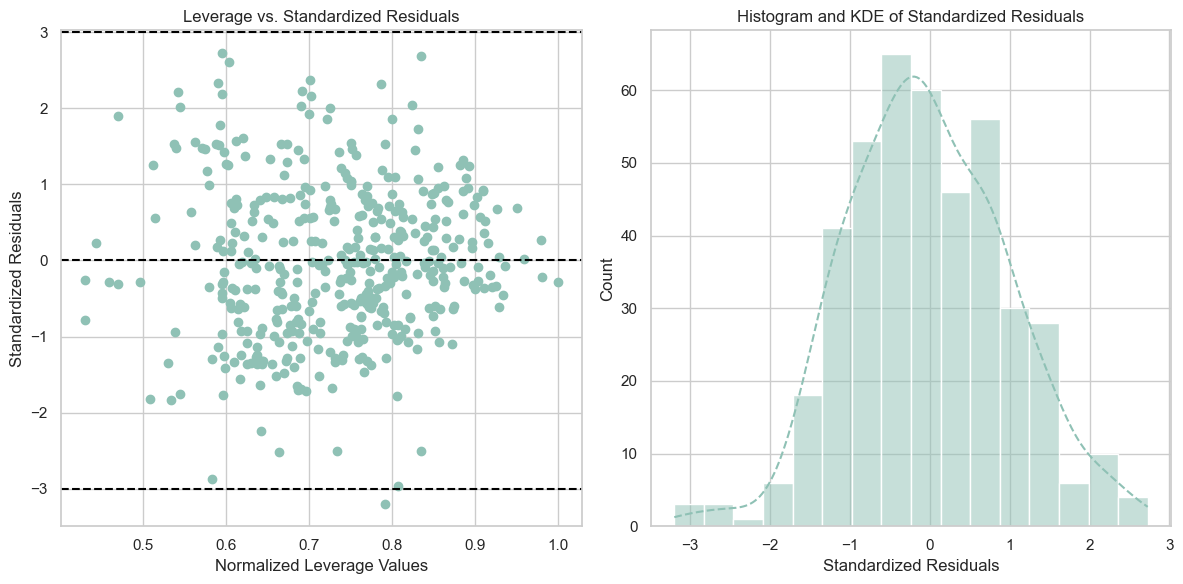

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate standardized residuals
residuals = y_test - y_pred
std_residuals = residuals / np.std(residuals)

# Save the model in a .pkl file
rf_model = final_models['RF']  

# Calculate leverage using a simplified method for RandomForest
depths = [tree.decision_path(X_test).sum(axis=1) for tree in rf_model.estimators_]
hat_values = np.array([np.mean([depth[i] for depth in depths]) for i in range(X_test.shape[0])])
hat_values_normalized = hat_values / np.max(hat_values)

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Custom color palette
custom_color = '#8FC1B5'  # Pale turquoise color
plt.figure(figsize=(12, 6))

# Scatter plot for leverage vs. standardized residuals
plt.subplot(1, 2, 1)
plt.scatter(hat_values_normalized, std_residuals, color=custom_color)
plt.xlabel('Normalized Leverage Values')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs. Standardized Residuals')
plt.axhline(y=0, linestyle='--', color='black')
plt.axhline(y=3, linestyle='--', color='black')
plt.axhline(y=-3, linestyle='--', color='black')
plt.grid(True)

# Histogram with Kernel Density Estimate
plt.subplot(1, 2, 2)
sns.histplot(std_residuals, kde=True, color=custom_color, line_kws={'color': 'black', 'linestyle': '--'})
plt.xlabel('Standardized Residuals')
plt.title('Histogram and KDE of Standardized Residuals')
plt.grid(True)
plt.savefig('../figures/Model_AD.svg', dpi=300, format='svg')

plt.tight_layout()
plt.show()

GBRT - Cross-validated R^2 (Q2): 0.90
RF - Cross-validated R^2 (Q2): 0.92
KNN - Cross-validated R^2 (Q2): 0.88
MLR - Cross-validated R^2 (Q2): 0.76


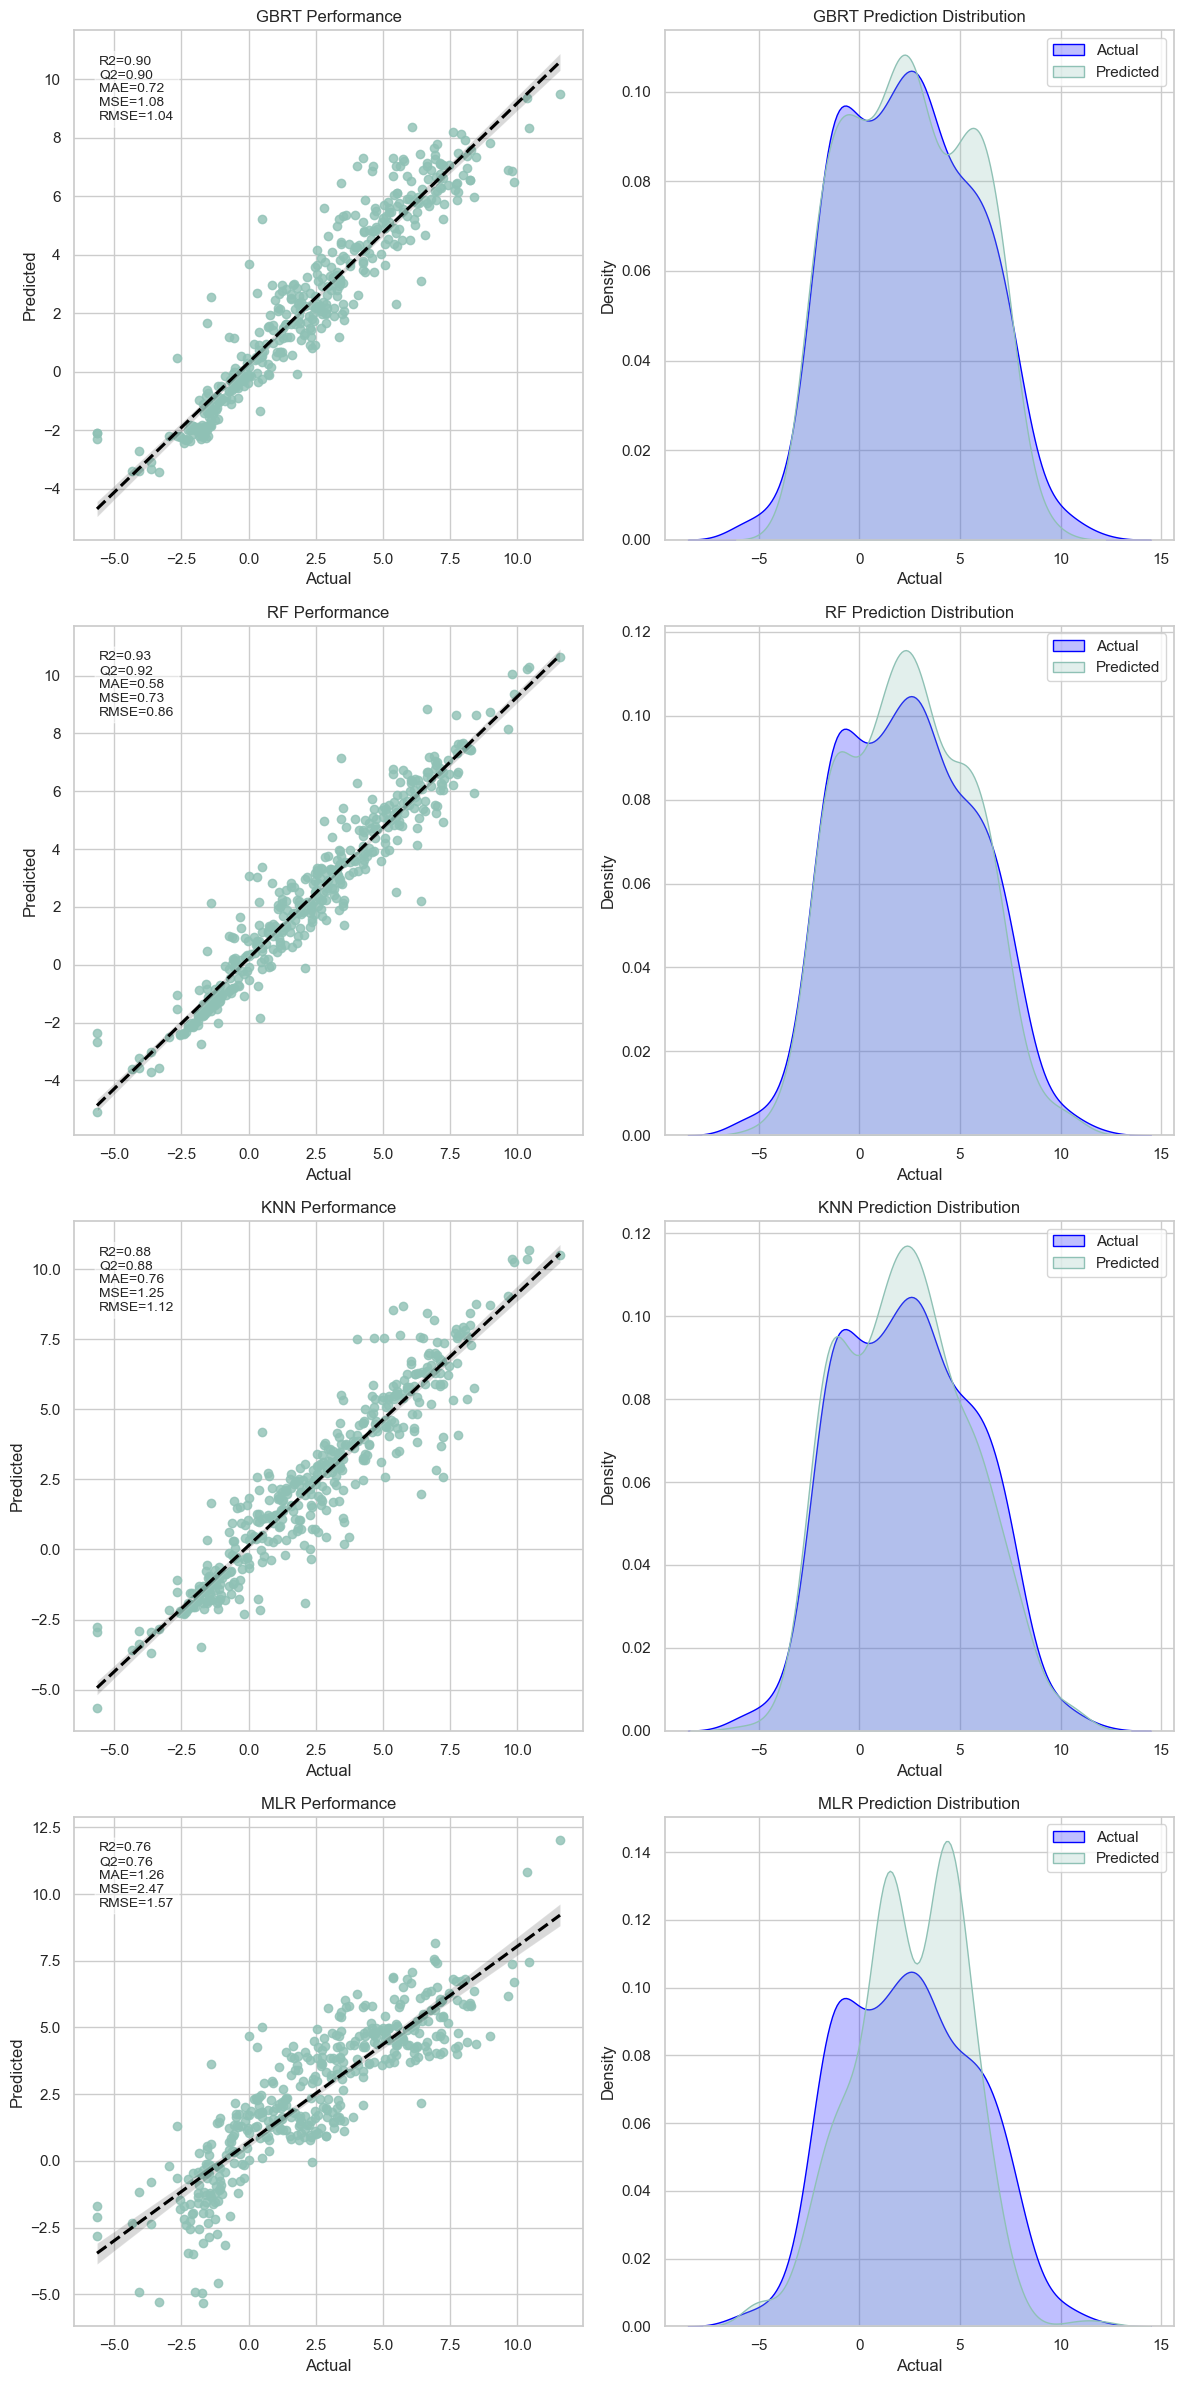

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set the theme and custom palette
sns.set_theme(style="whitegrid")
custom_palette = ['#8FC1B5'] 

# Caculate Q2 values
Q2_values = {}
for model_name, model in final_models.items():
    kf = KFold(n_splits=5)
    cross_val_scores = cross_val_score(model, X_train_full, y_train_full, cv=kf, scoring='r2')
    Q2 = np.mean(cross_val_scores)
    Q2_values[model_name] = Q2
    print(f"{model_name} - Cross-validated R^2 (Q2): {Q2:.2f}")

# Create canvas
fig, axs = plt.subplots(len(final_models), 2, figsize=(12, 6 * len(final_models)))
axs = axs.flatten()

# Caculate statistical magnitude
for i, (model_name, model) in enumerate(final_models.items()):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    Q2 = Q2_values[model_name]
    
    y_test_flat = np.ravel(y_test)
    y_pred_flat = np.ravel(y_pred)
    
    data = pd.DataFrame({'Actual': y_test_flat, 'Predicted': y_pred_flat})
    
    # Plot regression plot
    color = custom_palette[0]
    sns.regplot(x='Actual', y='Predicted', data=data, ax=axs[2*i],
                scatter_kws={'color': color}, 
                line_kws={'color': 'black', 'linestyle': '--'})
    axs[2*i].set_title(f'{model_name} Performance')
    
    # Plot prediction distribution
    sns.kdeplot(data['Actual'], fill=True, ax=axs[2*i + 1], color="blue", label="Actual")
    sns.kdeplot(data['Predicted'], fill=True, ax=axs[2*i + 1], color=color, label="Predicted")
    axs[2*i + 1].legend()
    axs[2*i + 1].set_title(f'{model_name} Prediction Distribution')
    
    # Add statistical magnitude
    textstr = f'R2={r2:.2f}\nQ2={Q2:.2f}\nMAE={mae:.2f}\nMSE={mse:.2f}\nRMSE={rmse:.2f}'
    axs[2*i].text(0.05, 0.95, textstr, transform=axs[2*i].transAxes, fontsize=10, verticalalignment='top', 
                  bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))

plt.tight_layout()
plt.savefig('../figures/Model_Performance.svg', dpi=300, format='svg')
plt.show()